In [1]:
import sys, os, re, gzip, json, random, math

import numpy as np
import sklearn
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.functional as F

import librosa
import librosa.display

import soundfile as sf

%matplotlib inline

In [2]:
data_path = '../data'
mp3com_path = '%s/mp3_com' % data_path

myspace_path = '%s/myspace_mp3s' % data_path
metadata_path = '%s/metadata.json.gz' % myspace_path
genre_map_path = '%s/genre_map.pkl' % myspace_path

features_path = '%s/audio_features' % data_path
melspec_path = '%s/melspec' % features_path

gen_path = 'generator.model'
discr_path = 'discriminator.model'
num_gpus = torch.cuda.device_count()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
#discrim cross ent loss with p true distr, q fake distr:  H(p,q) = - sum(p * log(q))
# H(q) = - 1/N sum( (y * log(p(y))) + ((1-y) * (log(1 - p(y)))) )
# push real preds to 1 and fake to 0 via log probability
# min(G)max(D) V(G, D) = Expectation(x ~ pdata(x))[log D(x)] + Expectation(z ~ pz(z))[log (1 - D(G(z)))]

In [4]:
def weights_init(m):
    classname = m.__class__.__name__
    #center conv weights on 0
    if 'Conv' in classname:
        m.weight.data.normal_(0.0, 0.02)
    #center batch norm wts on 1
    elif 'BatchNorm' in classname:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.num_gpus = torch.cuda.device_count()
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(4, 16), stride=2, padding=1, bias=False),
            #nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(4, 20), stride=3, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25), 
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(4, 16), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25), 
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(4, 16), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25), 
            
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(4, 16), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=256, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25), 
            
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(4, 16), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(num_features=512, momentum=0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25), 
            
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=(4, 20), stride=1, padding=0, bias=False),
            #nn.Conv2d(in_channels=256, out_channels=1, kernel_size=(4, 27), stride=4, padding=0, bias=False),
            nn.Sigmoid()
        )
        
        
    def forward(self, x):
        if x.is_cuda and self.num_gpus > 1:
            output = nn.parallel.data_parallel(self.model, x, range(self.num_gpus))
        else:
            output = self.model(x)

        return output.squeeze()

In [6]:
discriminator = Discriminator().to(device)
discriminator.apply(weights_init)

if os.path.exists(discr_path):
    print('Loading stored discriminator')
    discriminator.load_state_dict(torch.load(discr_path))
    
# Handle multi-gpu if desired
if (device.type == 'cuda') and (num_gpus > 1):
    discriminator = nn.DataParallel(discriminator, list(range(num_gpus)))
    
print(discriminator)

Loading stored discriminator
Discriminator(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 16), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Dropout2d(p=0.25, inplace=False)
    (3): Conv2d(32, 64, kernel_size=(4, 16), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): Dropout2d(p=0.25, inplace=False)
    (7): Conv2d(64, 128, kernel_size=(4, 16), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Dropout2d(p=0.25, inplace=False)
    (11): Conv2d(128, 256, kernel_size=(4, 16), stride=(2, 2), padding=(1, 1), bias=False)
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.8, affine=True, track_running_stats=True)
    (13): LeakyReLU(ne

In [7]:
class Generator(nn.Module):
    '''Takes a random vector and tries to generate a realistic target from it'''
    def __init__(self, latent_size):
        super(Generator, self).__init__()
        self.num_gpus = torch.cuda.device_count()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(in_channels=latent_size, out_channels=512, kernel_size=(4,12), stride=2, padding=1, bias=False),#4->8
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=(4,12), stride=2, padding=1, bias=False),#8->16
            #nn.ConvTranspose2d(in_channels=latent_size, out_channels=256, kernel_size=(4,12), stride=3, padding=1, bias=False),#8->16
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4,10), stride=2, padding=1, bias=False),#16->32
            #nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(4,11), stride=3, padding=1, bias=False),#16->32
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4,8), stride=2, padding=1, bias=False),#32->64
            #nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(4,10), stride=3, padding=1, bias=False),#32->64
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4,4), stride=2, padding=1, bias=False),#64->128
            #nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=(4,8), stride=3, padding=0, bias=False),#64->128
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=(4,4), stride=2, padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=(4,4), stride=2, padding=1, bias=False),
            #nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=(2,1), stride=3, padding=0, bias=False),
            
            #nn.Tanh()
        )
        
    def forward(self, z):
        if z.is_cuda and self.num_gpus > 1:
            output = nn.parallel.data_parallel(self.model, z, range(self.num_gpus))
        else:
            output = self.model(z)

        return output

In [8]:
latent_size = 1024

generator = Generator(latent_size).to(device)
generator.apply(weights_init)

if os.path.exists(gen_path):
    print('loading existing generator')
    generator.load_state_dict(torch.load(gen_path))
    
# Handle multi-gpu if desired
if (device.type == 'cuda') and (num_gpus > 1):
    generator = nn.DataParallel(generator, list(range(num_gpus)))
    
print(generator)

loading existing generator
Generator(
  (model): Sequential(
    (0): ConvTranspose2d(1024, 512, kernel_size=(4, 12), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 12), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 10), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 8), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), pa

In [9]:
lr = 5e-4
beta = 0.5

criterion = nn.BCELoss()

# setup optimizer
opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(beta, 0.999))
opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(beta, 0.999))

In [11]:
def get_samples(melspec_samples_path, sample_width, genres, max_samples):
    samples = []
    per_genre = max_samples//len(genres)
    
    for genre in genres:
        genre_path = '%s/%s' % (melspec_samples_path, genre)
        
        fns = [fn for fn in os.listdir(genre_path) if fn.endswith('.npy')]
        random.shuffle(fns)
        fns = fns[:50]
        per_file = per_genre//len(fns)
        
        for fn in fns:
            fp = '%s/%s' % (genre_path, fn)
            x = np.load(fp)

            max_idx = x.shape[1] - sample_width
            idx = np.arange(max_idx)
            np.random.shuffle(idx)

            for ix in idx[:per_file]:
                samples.append(torch.from_numpy(x[:, ix:ix+sample_width]))
        
    random.shuffle(samples)
    
    return samples

In [12]:
def train(discriminator, generator, criterion, opt_d, opt_g, 
          num_epochs, melspec_path, sample_width, max_samples, genres):
    torch.manual_seed(111)
    fixed_noise = torch.randn(1, latent_size, 1, 1, device=device)
    d_losses = []
    g_losses = []
    
    for epoch in range(1, num_epochs+1):
        print('Epoch %d' % epoch)
        d_ep_losses = []
        g_ep_losses = []

        samples = get_samples(melspec_path, sample_width, genres, max_samples)
        num_batches = math.ceil(len(samples)/batch_size)
        print('Samples: %d, Batches: %d' % (len(samples), num_batches))

        for batch in range(num_batches):
            if batch and batch%250==0:
                if batch:
                    print('  Batch %d, Avg Epoch Discr Loss: %.8f, Avg Epoch Gen Loss: %.8f' % (
                        batch, sum(d_ep_losses)/len(d_ep_losses), sum(g_ep_losses)/len(g_ep_losses)))
                save_and_sample(discriminator, generator, fixed_noise, epoch, batch)

            #stack batch samples, add empty channel dimension, [b, 1, 128, 2048]
            x_real = torch.stack(samples[batch*batch_size:(batch+1)*batch_size]).unsqueeze(1).to(device)
            if x_real.size(0)<=1:
                continue

            opt_d.zero_grad() #clear accumulated

            #how well does discriminator do with real samples?
            d_out_real = discriminator(x_real).squeeze()
            lab_real = torch.ones(x_real.size(0))
            d_loss_real = criterion(d_out_real, lab_real)

            #calc now? https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html
            d_loss_real.backward()


            #how well does discriminator do with fake samples created by the generator?
            noise = torch.randn(x_real.size(0), latent_size, 1, 1, device=device)
            x_fake = generator(noise) 

            #don't store grads for this step - use x_fake again for gen training and retain grads
            d_out_fake = discriminator(x_fake.detach())
            lab_fake = torch.zeros(x_real.size(0))
            d_loss_fake = criterion(d_out_fake, lab_fake)

            d_loss_fake.backward()

            #store loss
            d_loss = d_loss_real + d_loss_fake
            d_ep_losses.append(d_loss.item())

            #update discriminator params
            opt_d.step()


            # generator training step: maximize log(D(G(z)))
            opt_g.zero_grad()

            #we want the discriminator to do bad on the generator output
            d_g_out = discriminator(x_fake)

            #want this to be close to real bc we're trying to generate realisticly
            g_loss = criterion(d_g_out, lab_real) # -log D(G(z))

            #calc grads
            g_loss.backward()

            #store loss
            g_ep_losses.append(g_loss.item())

            #update generator params
            opt_g.step()

        d_losses.extend(d_ep_losses)
        g_losses.extend(g_ep_losses)

        save_and_sample(discriminator, generator, fixed_noise, epoch, batch)
        
    return discriminator, generator
    
    
def save_and_sample(discriminator, generator, fixed_noise, epoch, batch):
    print('saving models...')
    torch.save(discriminator.state_dict(), discr_path)
    torch.save(generator.state_dict(), gen_path)
    
    #generate a sample melspec
    fake_melspec = generator(fixed_noise).squeeze().detach().numpy()
    
    fig, ax = plt.subplots(figsize=(12,8))
    melspec_db = librosa.amplitude_to_db(np.abs(fake_melspec), ref=np.max)
    img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
    fig.colorbar(img, ax=ax, format="%+2.f dB")
    print('gan_melspec_bce_epoch%d_batch%d.png' % (epoch, batch))
    fig.savefig('gan_melspec_bce_epoch%d_batch%d.png' % (epoch, batch))
    fig.clf()
    
    if batch%1000==0:
        print('generating fake melspec audio...')
        n_fft=2048
        n_iter=32
        sr=22050
        fake_melspec_audio = librosa.feature.inverse.mel_to_audio(fake_melspec, sr=sr, n_fft=n_fft, n_iter=n_iter)
        print('gan_melspec_bce_audio_epoch%d_batch%d.wav' % (epoch, batch))
        sf.write('gan_melspec_bce_audio_epoch%d_batch%d.wav' % (epoch, batch), fake_melspec_audio, sr, 'PCM_24')

In [13]:
num_epochs = 15
sample_width = 1024
batch_size = 8
max_samples = 25000
genres = ['classical']
discriminator, generator = train(discriminator, generator, criterion, opt_d, opt_g, 
                                 num_epochs, melspec_path, sample_width, max_samples, genres)

Epoch 1
Samples: 24701, Batches: 3088
  Batch 250, Avg Epoch Discr Loss: 1.30476649, Avg Epoch Gen Loss: 7.27871091
saving models...
gan_melspec_bce_epoch1_batch250.png
  Batch 500, Avg Epoch Discr Loss: 1.21052844, Avg Epoch Gen Loss: 7.48199999
saving models...
gan_melspec_bce_epoch1_batch500.png
  Batch 750, Avg Epoch Discr Loss: 1.20058223, Avg Epoch Gen Loss: 7.50107279
saving models...
gan_melspec_bce_epoch1_batch750.png
  Batch 1000, Avg Epoch Discr Loss: 1.20933224, Avg Epoch Gen Loss: 7.61389700
saving models...
gan_melspec_bce_epoch1_batch1000.png
generating fake melspec audio...
gan_melspec_bce_audio_epoch1_batch1000.wav
  Batch 1250, Avg Epoch Discr Loss: 1.21587293, Avg Epoch Gen Loss: 7.46088385
saving models...
gan_melspec_bce_epoch1_batch1250.png
  Batch 1500, Avg Epoch Discr Loss: 1.18764023, Avg Epoch Gen Loss: 7.57741723
saving models...
gan_melspec_bce_epoch1_batch1500.png
  Batch 1750, Avg Epoch Discr Loss: 1.20389525, Avg Epoch Gen Loss: 7.51555480
saving models..

<ipython-input-12-4257988760bb>:93: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(12,8))


gan_melspec_bce_epoch2_batch2000.png
generating fake melspec audio...
gan_melspec_bce_audio_epoch2_batch2000.wav
  Batch 2250, Avg Epoch Discr Loss: 0.92011471, Avg Epoch Gen Loss: 7.12662265
saving models...
gan_melspec_bce_epoch2_batch2250.png
  Batch 2500, Avg Epoch Discr Loss: 0.90658179, Avg Epoch Gen Loss: 7.14036190
saving models...
gan_melspec_bce_epoch2_batch2500.png
  Batch 2750, Avg Epoch Discr Loss: 0.89146868, Avg Epoch Gen Loss: 7.13318207
saving models...
gan_melspec_bce_epoch2_batch2750.png
  Batch 3000, Avg Epoch Discr Loss: 0.87119222, Avg Epoch Gen Loss: 7.19911428
saving models...
gan_melspec_bce_epoch2_batch3000.png
generating fake melspec audio...
gan_melspec_bce_audio_epoch2_batch3000.wav
saving models...
gan_melspec_bce_epoch2_batch3119.png
Epoch 3
Samples: 24492, Batches: 3062
  Batch 250, Avg Epoch Discr Loss: 1.04224048, Avg Epoch Gen Loss: 7.39558138
saving models...
gan_melspec_bce_epoch3_batch250.png
  Batch 500, Avg Epoch Discr Loss: 1.06387278, Avg Epoch

KeyboardInterrupt: 

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

<Figure size 864x576 with 0 Axes>

In [84]:
print('saving models...')
torch.save(discriminator.state_dict(), discr_path)
torch.save(generator.state_dict(), gen_path)

saving models...


In [12]:
seed=504
torch.manual_seed(seed)
fixed_noise = torch.randn(1, latent_size, 1, 1, device=device)

In [13]:
fake_melspec = generator(fixed_noise).squeeze().detach().numpy()
print(fake_melspec.shape)

(128, 1024)


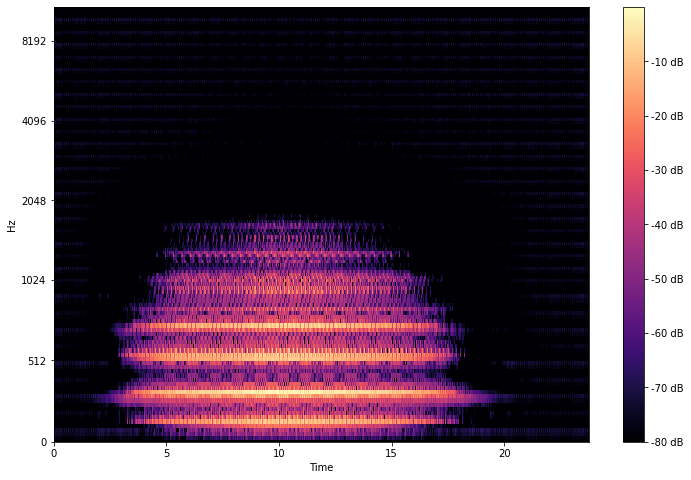

In [15]:
fig, ax = plt.subplots(figsize=(12,8))
melspec_db = librosa.amplitude_to_db(np.abs(fake_melspec), ref=np.max)
img = librosa.display.specshow(melspec_db, x_axis='time', y_axis='mel', ax=ax)
fig.colorbar(img, ax=ax, format="%+2.f dB")
#fig.savefig('gan_melspec_epoch%d.png' % epoch)

In [112]:
n_fft=2048
n_iter=32
sr=22050

fake_melspec_audio = librosa.feature.inverse.mel_to_audio(fake_melspec, sr=sr, n_fft=n_fft, n_iter=n_iter)
sf.write('fake_melspec_audio_%d.wav' % seed, fake_melspec_audio, sr, 'PCM_24')

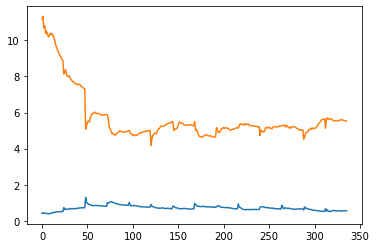

In [102]:
discr_loss = [0.41627100, 0.45005141, 0.40685149, 0.41725457, 0.40152508, 0.40695933, 0.39992878, 0.38831686, 0.37921291, 0.41360345, 0.42413947, 0.43882042, 0.45458504, 0.44688170, 0.47004189, 0.48623029, 0.49219222, 0.49225665, 0.49462245, 0.49823012, 0.50401041, 0.50943839, 0.50894390, 0.51182135, 0.72848580, 0.61535725, 0.65292026, 0.63464887, 0.63580438, 0.64794041, 0.65149653, 0.68440171, 0.66651346, 0.65669187, 0.66173803, 0.67138920, 0.68003303, 0.67019907, 0.67706920, 0.69283398, 0.70213484, 0.69921260, 0.71605121, 0.71976311, 0.71855066, 0.71729580, 0.72297359, 0.72838768, 1.29776430, 1.00675893, 0.97063908, 0.91771705, 0.90834296, 0.87639741, 0.85051251, 0.85601337, 0.83654571, 0.84608212, 0.84300403, 0.85701689, 0.84986829, 0.83600597, 0.84005712, 0.83648534, 0.83813770, 0.82808094, 0.82580514, 0.81740181, 0.80901181, 0.80576582, 0.80744416, 0.80232437, 0.99938751, 0.98517773, 0.99023325, 1.04358608, 1.05710305, 1.03982212, 1.01681223, 0.98994128, 0.97877865, 0.97136892, 0.95028666, 0.93044802, 0.92357190, 0.89698750, 0.89721837, 0.88110626, 0.88123386, 0.87357487, 0.87132816, 0.87191823, 0.86864882, 0.86638471, 0.86293203, 0.85729236, 1.01831371, 0.88929611, 0.81937253, 0.83087269, 0.84262202, 0.83922751, 0.84248184, 0.83954723, 0.82538822, 0.81490728, 0.80878619, 0.78730226, 0.78036142, 0.78180657, 0.77251309, 0.77234071, 0.76803979, 0.76636464, 0.75816798, 0.75612270, 0.75782928, 0.75572147, 0.75874535, 0.76126978, 0.90184257, 0.80933727, 0.78480708, 0.75435348, 0.74888791, 0.72446916, 0.71081636, 0.70643802, 0.69996761, 0.69408925, 0.69104802, 0.70834944, 0.71215576, 0.71348011, 0.69675222, 0.68005885, 0.68480598, 0.68803219, 0.68397709, 0.68451748, 0.68222500, 0.67740282, 0.67285623, 0.66589558, 0.80206113, 0.79412570, 0.76314164, 0.71979803, 0.71931252, 0.70214870, 0.68365863, 0.67092151, 0.67182597, 0.66605036, 0.66892281, 0.67260848, 0.68510017, 0.68147879, 0.67652100, 0.66509316, 0.66203681, 0.65490350, 0.64848958, 0.64757634, 0.64421369, 0.65184832, 0.65809128, 0.65455842, 0.95881156, 0.88667609, 0.85437676, 0.80541975, 0.79582475, 0.79800502, 0.77929685, 0.78969237, 0.79998500, 0.79188287, 0.79316891, 0.78269588, 0.77674180, 0.77218232, 0.76834633, 0.76861527, 0.77183344, 0.76943575, 0.77186137, 0.75869103, 0.75272726, 0.75323146, 0.75055724, 0.74327180, 0.79368494, 0.78401268, 0.84195692, 0.82547632, 0.77035527, 0.74721273, 0.74608630, 0.74717148, 0.74042035, 0.72942913, 0.73299607, 0.72943656, 0.72918646, 0.71840885, 0.72292433, 0.71304066, 0.70083332, 0.69392609, 0.67752844, 0.67847592, 0.66464729, 0.66331083, 0.65829164, 0.65885725, 0.93333161, 0.75405877, 0.74475212, 0.70699850, 0.65310576, 0.63957017, 0.61970673, 0.61752387, 0.61666198, 0.61458167, 0.62213080, 0.62177111, 0.62304585, 0.62660575, 0.62536496, 0.62047708, 0.62870972, 0.62330536, 0.62593335, 0.62263551, 0.62622362, 0.62353112, 0.62027291, 0.61651867, 0.74738943, 0.78433429, 0.77721039, 0.76487768, 0.77815378, 0.74765991, 0.73983401, 0.72663614, 0.71590908, 0.73248135, 0.70892029, 0.69754019, 0.69944153, 0.70563651, 0.68996632, 0.68791698, 0.67533418, 0.66808369, 0.66944117, 0.66429479, 0.66715816, 0.65839834, 0.65418068, 0.65086118, 0.85661084, 0.75206097, 0.66305641, 0.70789514, 0.70622934, 0.70497930, 0.68315463, 0.69430401, 0.68655924, 0.67691712, 0.67148546, 0.65115892, 0.64324348, 0.64511798, 0.63296144, 0.64420306, 0.64298195, 0.64803255, 0.65904878, 0.66216022, 0.66076045, 0.65981587, 0.65270652, 0.64845459, 0.59812344, 0.76856130, 0.68913449, 0.68351710, 0.68868296, 0.64154374, 0.63317823, 0.63434072, 0.62415921, 0.60673654, 0.58819576, 0.59004280, 0.58052752, 0.57167158, 0.56844928, 0.55626658, 0.54916253, 0.53863072, 0.53431542, 0.53577359, 0.52236690, 0.52651778, 0.52038230, 0.52083238, 0.67052899, 0.54359047, 0.60066069, 0.53499153, 0.51649856, 0.51401762, 0.52515369, 0.55714066, 0.56928181, 0.56902501, 0.56280120, 0.54745560, 0.53828204, 0.54197096, 0.55690982, 0.55991754, 0.54922347, 0.54093064, 0.54880998, 0.55407067, 0.55992571, 0.56245024, 0.55986014, 0.55110452]
gen_loss = [11.17128690, 11.34118599, 10.69082037, 10.80061238, 10.38549331, 10.51990621, 10.34615928, 10.19338452, 10.25171451, 10.39806310, 10.35708502, 10.38635350, 10.24527796, 10.17631003, 9.99721602, 9.75533730, 9.60885720, 9.47929885, 9.34826378, 9.22149340, 9.13429848, 9.04497040, 8.96095483, 8.85722826, 8.13234923, 8.23175057, 8.37201621, 8.08632868, 8.00664539, 7.99872494, 8.02973392, 7.89691067, 7.82859344, 7.75872112, 7.72324610, 7.66911638, 7.62362308, 7.59681226, 7.59734197, 7.54703950, 7.55532804, 7.57681560, 7.53234471, 7.44421077, 7.44260181, 7.39233766, 7.33764231, 7.30963957, 5.07814154, 5.25283007, 5.47398290, 5.52346683, 5.46924378, 5.69301920, 5.80968208, 5.93176906, 5.94949871, 5.96719026, 6.02365063, 5.97394152, 5.93031427, 5.96710564, 5.94684679, 5.92163416, 5.91674065, 5.88635288, 5.83526822, 5.85588586, 5.86225553, 5.89028701, 5.88847512, 5.89232410, 5.85075536, 5.59763817, 5.18586020, 5.09400211, 4.99666977, 4.83164604, 4.83643951, 4.77825361, 4.77681411, 4.74769227, 4.84733253, 4.88291347, 4.91572702, 4.97163007, 4.95946312, 4.96458628, 4.95405875, 4.91054289, 4.89794316, 4.92613472, 4.93879718, 4.95558169, 4.96160211, 4.97980813, 5.00989522, 4.85942018, 4.82768209, 4.79305750, 4.70963617, 4.76765205, 4.76029260, 4.72591902, 4.74623061, 4.76524148, 4.78360572, 4.85449406, 4.87914623, 4.86615277, 4.91328642, 4.92801900, 4.91940828, 4.93626861, 4.98333483, 4.96904366, 4.97763642, 4.99272833, 4.99934461, 4.98885846, 4.18069297, 4.58810097, 4.72749862, 4.79977996, 4.86115319, 4.83858867, 4.84324083, 5.00356985, 5.08576044, 5.11218228, 5.18763245, 5.25594680, 5.22463331, 5.24562778, 5.24899407, 5.26250294, 5.31065688, 5.35025298, 5.37682341, 5.40222670, 5.41147006, 5.43415666, 5.43994750, 5.49899440, 5.49488476, 5.00630855, 5.09954183, 5.09087982, 5.10315691, 5.17439962, 5.32299633, 5.47457734, 5.45885950, 5.39812194, 5.41746065, 5.38815453, 5.32113645, 5.29195255, 5.28720487, 5.30264210, 5.32337875, 5.31158440, 5.30291366, 5.32645777, 5.31280072, 5.29490843, 5.26961066, 5.27425498, 5.49144845, 5.02142179, 5.05851397, 4.96395018, 4.77212457, 4.68356946, 4.65971554, 4.66137920, 4.64080635, 4.64474407, 4.69999042, 4.73209782, 4.76936112, 4.75937556, 4.75058802, 4.70789442, 4.69949061, 4.71398700, 4.69639194, 4.65988248, 4.63838702, 4.65004690, 4.64706640, 4.65815561, 5.16392495, 5.06909457, 4.90654926, 4.88022952, 4.96517523, 5.07501759, 5.13106543, 5.11623335, 5.17498084, 5.12864861, 5.16190394, 5.15343670, 5.12557085, 5.11141199, 5.06209239, 5.03215135, 5.03758179, 5.06859416, 5.07011040, 5.07937477, 5.10312116, 5.12995270, 5.15434594, 5.16731010, 5.13316069, 5.27175618, 5.36880136, 5.38136133, 5.34101363, 5.32097021, 5.30473433, 5.38896195, 5.32420894, 5.35734095, 5.35849657, 5.36202190, 5.32202771, 5.27332269, 5.28248036, 5.26857798, 5.27049742, 5.24856804, 5.23275428, 5.23656348, 5.24207865, 5.21801353, 5.20576034, 5.21098675, 4.71578135, 5.02822750, 4.97376380, 4.93754133, 4.91620157, 5.00674152, 5.13399471, 5.18742294, 5.15176431, 5.13952892, 5.19066648, 5.13942845, 5.12517046, 5.10099703, 5.18381032, 5.21225232, 5.22921944, 5.21445197, 5.19376312, 5.20892038, 5.21401875, 5.24300563, 5.26518093, 5.25549881, 5.27317472, 5.29667230, 5.30551459, 5.27336772, 5.20162157, 5.29978192, 5.23166606, 5.16399864, 5.14995825, 5.21092489, 5.13720562, 5.17554795, 5.23556361, 5.22174899, 5.19899350, 5.18552103, 5.13932527, 5.10330756, 5.08587733, 5.04378943, 5.01103690, 5.04316476, 5.03757258, 5.04167590, 4.52094486, 4.63987794, 4.84285441, 4.90696029, 4.90942054, 4.98541180, 5.06631948, 5.05195386, 5.14112322, 5.07782880, 5.14219633, 5.12476781, 5.12541154, 5.12317827, 5.21090026, 5.26706047, 5.35997530, 5.42300497, 5.45686732, 5.55201093, 5.61628694, 5.63060863, 5.63890121, 5.65392164, 5.13126106, 5.63903037, 5.70497131, 5.62627623, 5.65787094, 5.62977402, 5.66726385, 5.62171105, 5.57499023, 5.55729052, 5.53969437, 5.54608377, 5.53250559, 5.54236377, 5.55408283, 5.57162273, 5.56010801, 5.61019160, 5.60901314, 5.58339476, 5.55889953, 5.55943910, 5.53315650, 5.53193915]
plt.plot(discr_loss)
plt.plot(gen_loss)
plt.show()